In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import datetime,date,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os

In [2]:
#Input Working directory or directory you want to work in
dirname=input("Enter the current working directory")
os.chdir(dirname)# Set current working directory
os.getcwd() # Get current working directory


Enter the current working directory/Users/shivamgoel/Desktop/Python/final


'/Users/shivamgoel/Desktop/Python/final'

In [3]:
airlines_data = pd.read_csv('data/airlines.csv',low_memory=False,error_bad_lines=False,warn_bad_lines=False, skipinitialspace=True)
airports_data = pd.read_csv('data/airports.csv',low_memory=False,error_bad_lines=False,warn_bad_lines=False, skipinitialspace=True)
flights = pd.read_csv('data/flights.csv',low_memory=False,error_bad_lines=False,warn_bad_lines=False, skipinitialspace=True,
                           na_values=['NA      ', 'NA    ', 'NA   ', 'NA', 'NA ', 'NA ', 'NaN', 'NAN', ''])

In [4]:
#Shapping Data
airlines_data.shape[0] #no of rows=14
airlines_data.shape[1] #no of columns=2

airports_data.shape[0] #no of rows=322
airports_data.shape[1] #no of columns=7

flights.shape[0] #no of rows = 5819079
flights.shape[1] #no of columns = 31
airports_data.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [5]:
unique_flights_data = {}
for item in flights.columns:
    unique_flights_data[item] = flights[item].unique()
#unique_flights_data

In [6]:
day_of_week_desc={
    1:'Monday',
    2:'Tuesday',
    3:'Wednesday',
    4:'Thursday',
    5:'Friday',
    6:'Saturday',
    7:'Sunday'
}
flights['DESC_DOW']=flights['DAY_OF_WEEK'].apply(lambda a:day_of_week_desc[a])


In [7]:
airlines_dict = dict(zip(airlines_data['IATA_CODE'],airlines_data['AIRLINE']))
airport_dict = dict(zip(airports_data['IATA_CODE'],airports_data['AIRPORT']))
flights['DESC_AIRLINE'] = flights['AIRLINE'].apply(lambda x: airlines_dict[x])
flights.head()['DESC_AIRLINE']

0      Alaska Airlines Inc.
1    American Airlines Inc.
2           US Airways Inc.
3    American Airlines Inc.
4      Alaska Airlines Inc.
Name: DESC_AIRLINE, dtype: object

# Which airlines is the best?

*So,let's create a ranking module for airlines.We will store the relevant information throughout the process.
Following are the factors that decide the rank of an airline.*
* Highest Ratio of (Operated flights)/(Scheduled flights)
* Flight speed
* Average arrival delay
* Flight volume
* Taxi In and Out Time

In [8]:
#Each airline is either cancelled or operated.
rank_airlines = pd.DataFrame(flights.groupby('DESC_AIRLINE').count()['SCHEDULED_DEPARTURE'])
rank_airlines['CANCELLED']=flights.groupby('DESC_AIRLINE').sum()['CANCELLED']
rank_airlines['OPERATED']=rank_airlines['SCHEDULED_DEPARTURE']-rank_airlines['CANCELLED']
rank_airlines['RATIO_OP_SCH']=rank_airlines['OPERATED']/rank_airlines['SCHEDULED_DEPARTURE']
rank_airlines.drop(rank_airlines.columns[[0,1,2]],axis=1,inplace=True)
rank_airlines.head()

,RATIO_OP_SCH
DESC_AIRLINE,
Alaska Airlines Inc.,0.996122
American Airlines Inc.,0.984960
American Eagle Airlines Inc.,0.949004
Atlantic Southeast Airlines,0.973371
Delta Air Lines Inc.,0.995634


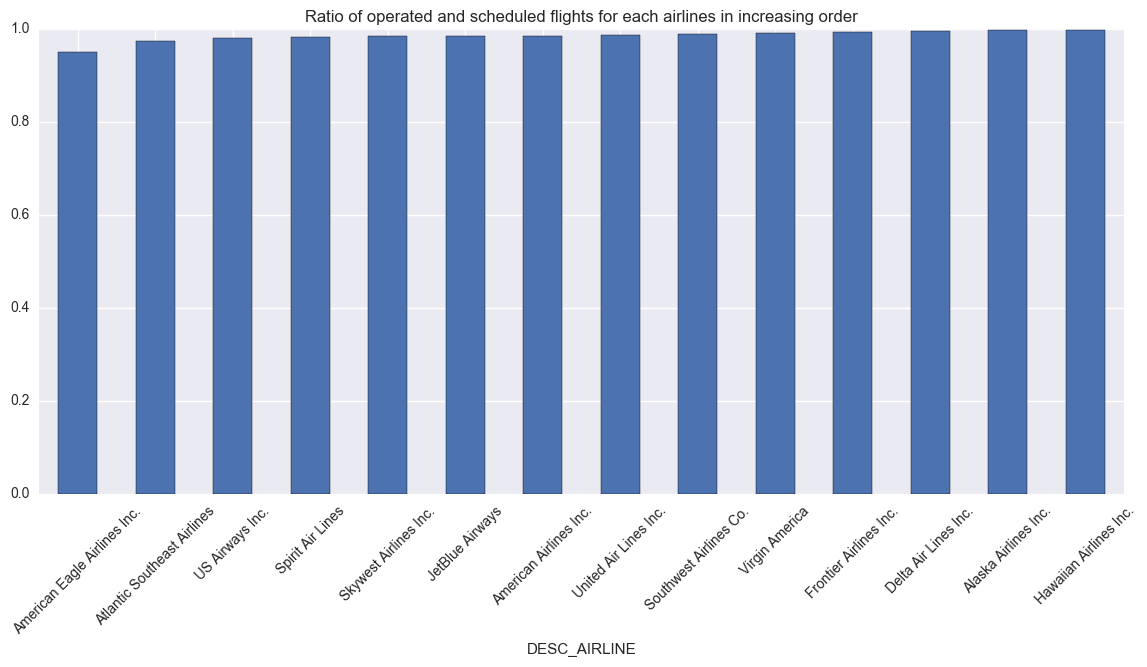

In [9]:
rank_airlines.sort_values(['RATIO_OP_SCH'],inplace=True)
# rank_airlines.head()
rank_airlines['RATIO_OP_SCH'].plot(kind='bar',figsize=(14,6),rot=45)
plt.title('Ratio of operated and scheduled flights for each airlines in increasing order')

plt.show()

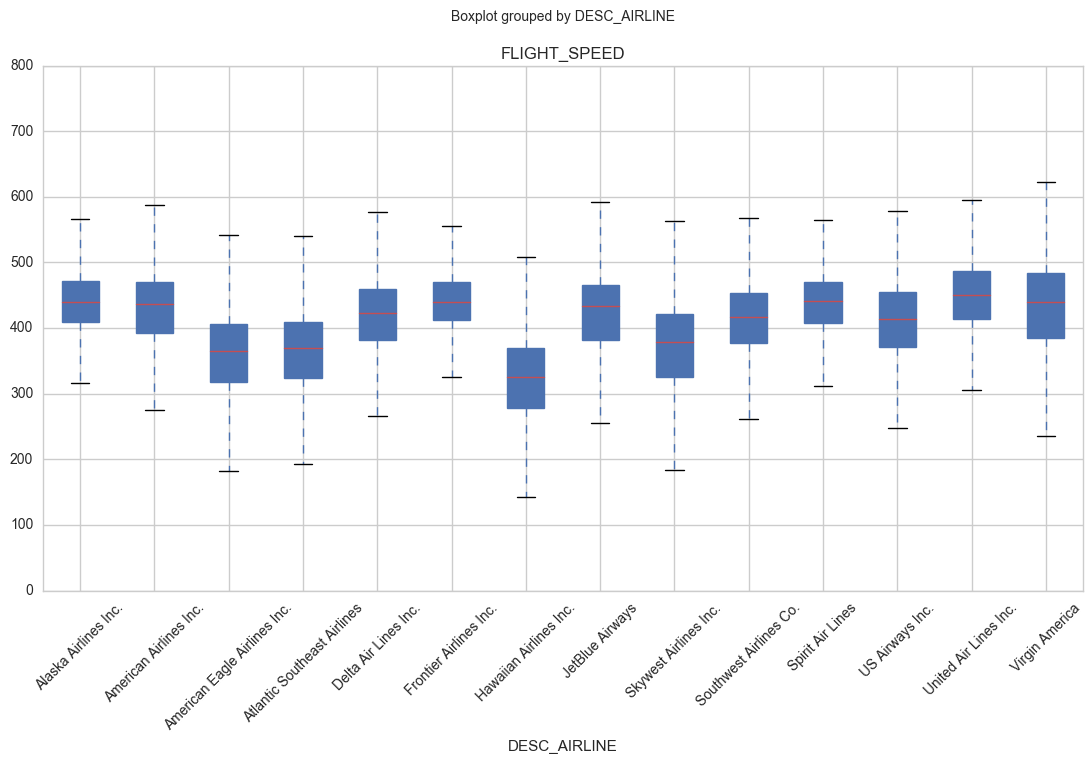

In [10]:
flights['FLIGHT_SPEED'] = 60*flights['DISTANCE']/flights['AIR_TIME']
rank_airlines['FLIGHT_SPEED'] = flights.groupby('DESC_AIRLINE')['FLIGHT_SPEED'].mean()
sns.set_style("whitegrid")
flights[['DESC_AIRLINE','FLIGHT_SPEED']].boxplot(column = 'FLIGHT_SPEED',by='DESC_AIRLINE',figsize=(13,7),rot=45,patch_artist=True)


In [11]:
flights.groupby('DESC_AIRLINE')[['ARRIVAL_DELAY','DEPARTURE_DELAY']].mean()
#Let's add arrival delay to our ranking module as well.
rank_airlines['ARRIVAL_DELAY']= flights.groupby('DESC_AIRLINE')['ARRIVAL_DELAY'].mean()
#As our flight speed is in miles/hour,it's probably best to keep ARRIVAL DELAY in hours.
rank_airlines['ARRIVAL_DELAY']=rank_airlines['ARRIVAL_DELAY'].apply(lambda x:x/60)
rank_airlines.head()

,RATIO_OP_SCH,FLIGHT_SPEED,ARRIVAL_DELAY
DESC_AIRLINE,,,
American Eagle Airlines Inc.,0.949004,360.899443,0.107631
Atlantic Southeast Airlines,0.973371,364.683738,0.109756
US Airways Inc.,0.979534,411.108496,0.061770
Spirit Air Lines,0.982927,436.499865,0.241197
Skywest Airlines Inc.,0.983071,368.598815,0.097428


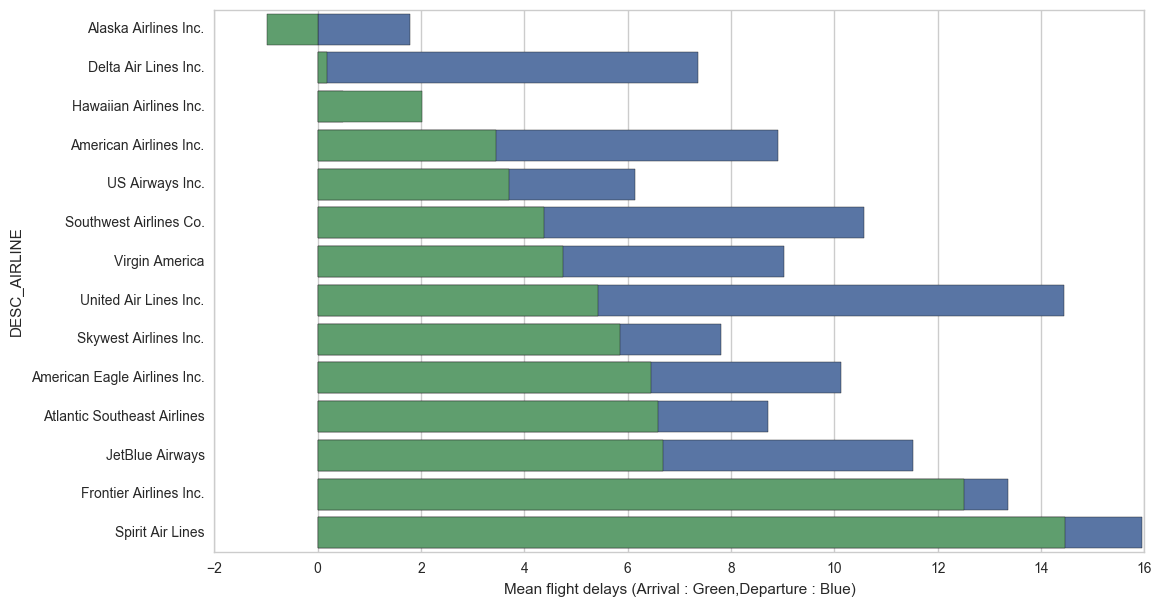

In [12]:
df_delay = pd.DataFrame(flights.groupby('DESC_AIRLINE')[['ARRIVAL_DELAY','DEPARTURE_DELAY']].mean())
df_delay.sort_values(['ARRIVAL_DELAY','DEPARTURE_DELAY'],ascending = [1,1],inplace=True)
plt.figure(figsize=(12,7))
sns.set_color_codes("deep")
sns.set_context(font_scale=2.5)
sns.set_style("whitegrid")
plot = sns.barplot(x='DEPARTURE_DELAY',y=df_delay.index,data = df_delay,color = 'b')
plot = sns.barplot(x='ARRIVAL_DELAY',y=df_delay.index,data = df_delay,color = 'g')
plot.set(xlabel='Mean flight delays (Arrival : Green,Departure : Blue)')

(-2.0, 16.0, 13.4, -0.40000000000000002)

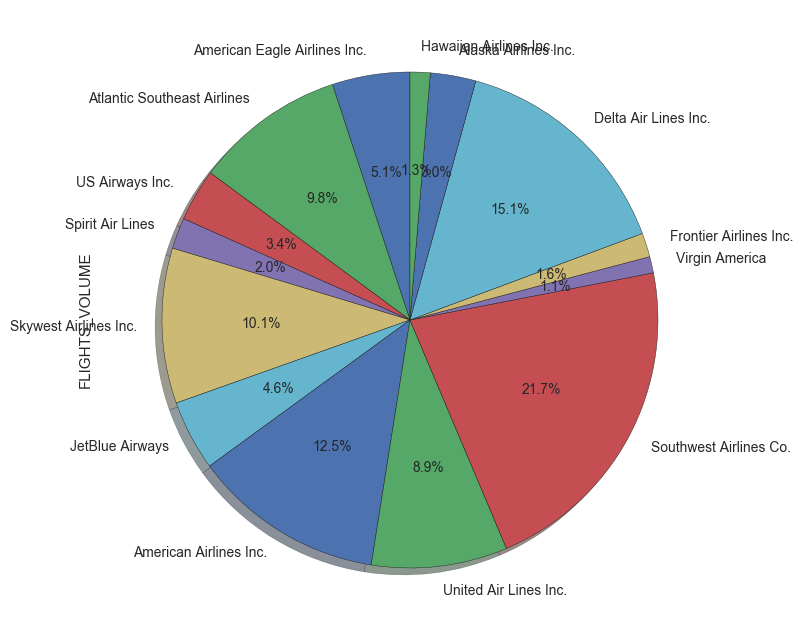

In [13]:
rank_airlines['FLIGHTS_VOLUME'] = flights.groupby('DESC_AIRLINE')['FLIGHT_NUMBER'].count()
#Let's change it into ratio of flight_vol/total flight_vol
total = rank_airlines['FLIGHTS_VOLUME'].sum()
rank_airlines['FLIGHTS_VOLUME'] = rank_airlines['FLIGHTS_VOLUME'].apply(lambda x:(x/float(total)))
rank_airlines['FLIGHTS_VOLUME'].plot.pie(figsize=(8,8),autopct='%1.1f%%',shadow=True, startangle=90)
plot.axis('equal') 

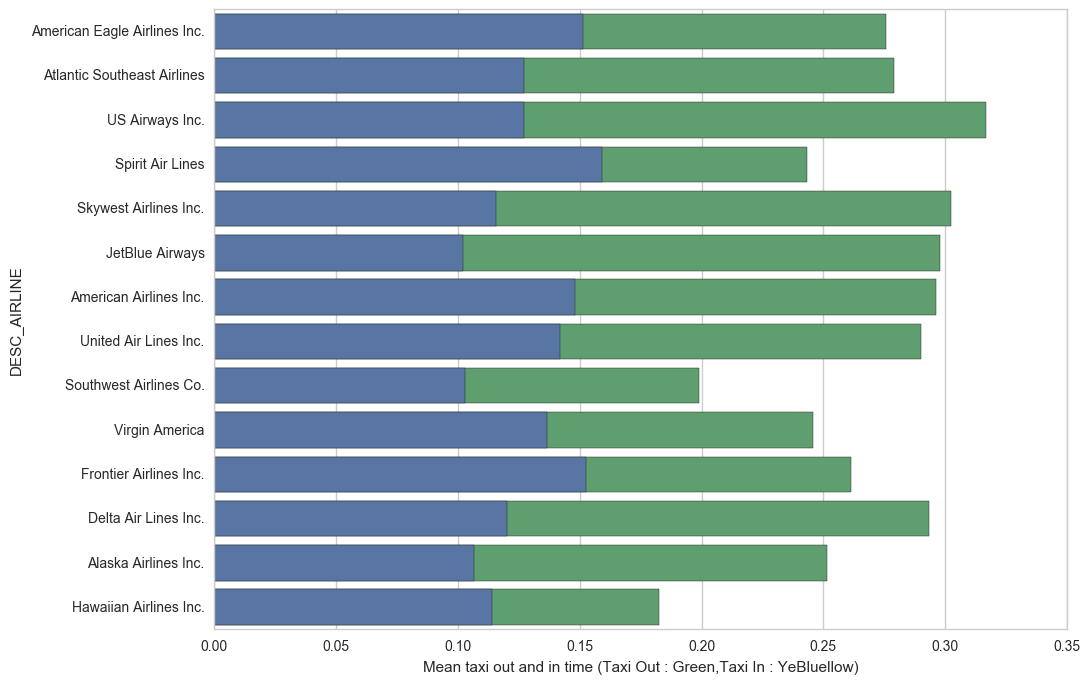

In [14]:
rank_airlines[['TAXI_IN','TAXI_OUT']] = flights.groupby('DESC_AIRLINE')[['TAXI_IN','TAXI_OUT']].mean()
#Taxi in and out time are in minutes.Let's change them to hours.
# rank_airlines[['TAXI_IN','TAXI_OUT']] = rank_airlines[['TAXI_IN','TAXI_OUT']].apply(lambda x, y : (x/float(60),y/float(60)))
rank_airlines['TAXI_IN'] = rank_airlines['TAXI_IN'].apply(lambda x:(x/float(60)))
rank_airlines['TAXI_OUT'] = rank_airlines['TAXI_OUT'].apply(lambda x:(x/float(60)))
plt.figure(figsize=(11, 8))
sns.set_color_codes("deep")
sns.set_context(font_scale=2.5)
plot = sns.barplot(x='TAXI_OUT',y=rank_airlines.index,data = rank_airlines,color = 'g')
plot = sns.barplot(x='TAXI_IN',y=rank_airlines.index,data = rank_airlines,color = 'b')
plot.set(xlabel='Mean taxi out and in time (Taxi Out : Green,Taxi In : YeBluellow)')



In [16]:
# I have scaled the data to 1-2
for i in rank_airlines.columns:
    rank_airlines[i] = ((rank_airlines[i]-rank_airlines[i].min())/(rank_airlines[i].max()-rank_airlines[i].min()))+1
a = rank_airlines.RATIO_OP_SCH*rank_airlines.FLIGHT_SPEED*rank_airlines.FLIGHTS_VOLUME
b = rank_airlines.ARRIVAL_DELAY*rank_airlines.TAXI_IN*rank_airlines.TAXI_OUT
rank_airlines['SCORE'] = a/(1+b)
rank_airlines.sort_values(['SCORE'],ascending=False,inplace=True)


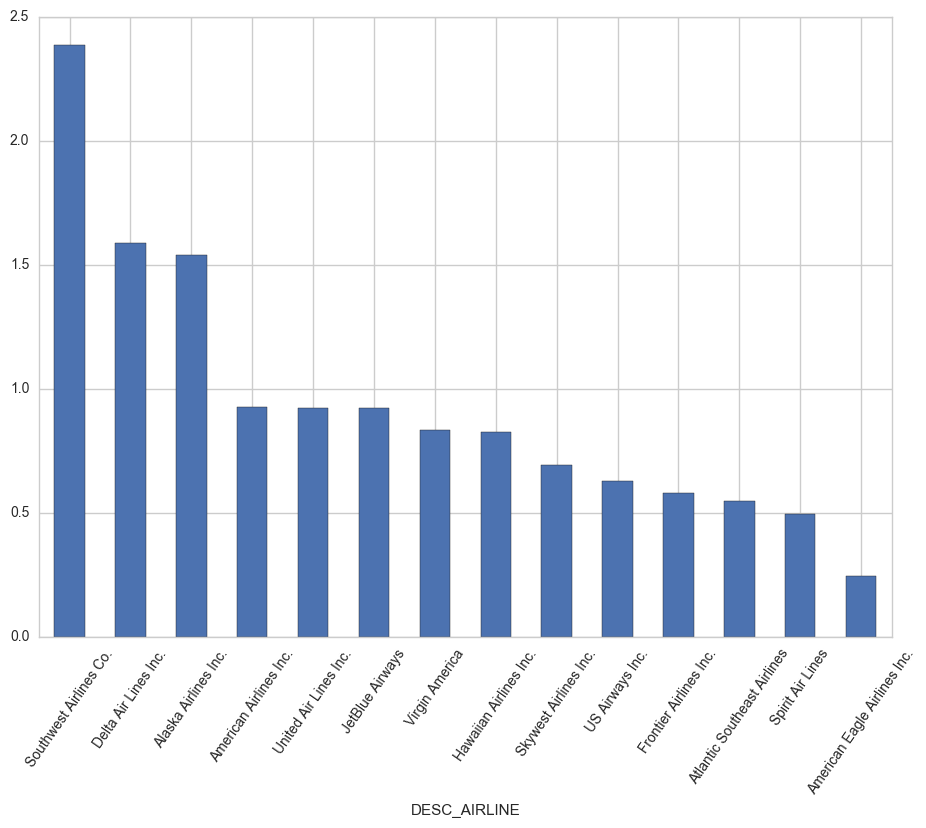

In [17]:
sns.set_style("whitegrid")
rank_airlines['SCORE'].plot.bar(figsize = (11,8),rot=55)
